# Self-knowledge in commentaries on book 3

This notebook contains the quantitative analyses of the doctrinal network for the chapter on book 3.

## Database note

I am using a different schema that enables more detailed analysis of doctrines. 
Using the `(:Instance)` node as a blank node between a `(:Question)` and a `(:Doctrine)` no doctrine is embedded in a fixed structure. It is in stead possible to determine the specific use of a doctrine by any given commentator, and it does not need to be reflected by any others.

# Analysis

## Setup

In [664]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from os import path

from utilities import save_table, print_figure_inclusion, build_matrix

from py2neo import Graph
graph = Graph('https://hobby-ijiahihliahcgbkepnpggmbl.dbs.graphenedb.com:24780/db/data/',
              user='remote',
              password="b.WKJhDFo38DGT.XBFHkuTL7R6BEEgw")

sns.set_context("paper", font_scale=1.5)

#pd.set_option('display.max_colwidth', -1)

In [6]:
author_names = graph.run('MATCH (n:Author) where not n.name = "Aristotle" RETURN n.name ORDER BY n.name asc').to_data_frame()['n.name']

In [7]:
author_names

0              Anonymus Assisi
1               Anonymus Bazan
2            Anonymus Digby 55
3    Anonymus Vat. Lat. 2170 2
4            Henric de la Wyle
5                John Dinsdale
6               John of Jandun
7              Radulphus Brito
8             Siger of Brabant
9           Simon of Faversham
Name: n.name, dtype: object

## Quantities

In [685]:
# Number of doctrines
q = ("MATCH (d:Doctrine) RETURN count(d)")
total_doctrines = graph.run(q).evaluate()

# Number of instances
q = ("MATCH (i:Instance) RETURN count(i)")
total_instances = graph.run(q).evaluate()

# Number of conclusion doctrines
q = ("MATCH (i:Instance {type:'Conclusion'})-[:OF]->(d:Doctrine) "
     "RETURN count(distinct d)")
conclusion_doctrines = graph.run(q).evaluate()

# Number of conclusion instances
q = ("MATCH (i:Instance {type:'Conclusion'}) RETURN count(i)")
conclusion_instances =  graph.run(q).evaluate()

# Number of positive doctrines (doctrines with instances that are not in a rationes context)
q = ("MATCH (i:Instance)--(d:Doctrine) "
     "WHERE not exists(i.type) or i.type = 'Conclusion' "
     "RETURN count(distinct d)")
positive_doctrines =  graph.run(q).evaluate()

# Number of instances of positive doctrines
q = ("MATCH (i:Instance)--(d:Doctrine) "
     "WHERE not exists(i.type) or i.type = 'Conclusion' "
     "RETURN count(distinct i)")
positive_instances =  graph.run(q).evaluate()

# Number of attacks doctrines
q = ("MATCH (i:Instance {type:'Attack'})-[:OF]->(d:Doctrine) "
     "RETURN count(distinct d)")
attack_doctrines = graph.run(q).evaluate()

# Number of attack instances
q = ("MATCH (i:Instance {type:'Attack'}) "
     "RETURN count(i)")
attack_instances = graph.run(q).evaluate()

# Number of refutation doctrines
q = ("MATCH (i:Instance {type:'Refutation'})-[:OF]->(d:Doctrine) "
     "RETURN count(distinct d)")
refutation_doctrines = graph.run(q).evaluate()

# Number of refutation instances
q = ("MATCH (i:Instance {type:'Refutation'}) "
     "RETURN count(i)")
refutation_instances = graph.run(q).evaluate()

In [686]:
quantities = {
    'All': [total_doctrines, total_instances, round(total_doctrines / total_instances, 2)],
    'Determination': [positive_doctrines, positive_instances, round(positive_doctrines / positive_instances, 2)],
    # 'Conclusions': [conclusion_doctrines, conclusion_instances, round(conclusion_doctrines / conclusion_instances, 2)],
    'Attack': [attack_doctrines, attack_instances, round(attack_doctrines / attack_instances, 2)],
    'Refutation': [refutation_doctrines, refutation_instances, round(refutation_doctrines / refutation_instances, 2)]
}
data = pd.DataFrame(quantities)
data.index = ['Doctrines', 'Instances', 'Proportion']
data.index.name = 'Context'
sum_table = data[['Determination', 'Attack', 'Refutation', 'All']].T
sum_table[['Doctrines', 'Instances']] = sum_table[['Doctrines', 'Instances']].astype(int)
sum_table

Context,Doctrines,Instances,Proportion
Determination,33,90,0.37
Attack,25,58,0.43
Refutation,23,54,0.43
All,70,202,0.35


In [687]:
save_table(
    filename='../thesis/data/tables/doctrines-instances.tex',
    table=sum_table.to_latex(),
    caption='Number of doctrines and instances in four different context classes.',
    label='tab:science:quantities:doctrines-instances'
)

Printed the following table to ../thesis/data/tables/doctrines-instances.tex:
 \begin{table}
\centering
\begin{tabular}{lrrr}
\toprule
Context &  Doctrines &  Instances &  Proportion \\
\midrule
Determination &  33 &  90 &  0.37 \\
Attack        &  25 &  58 &  0.43 \\
Refutation    &  23 &  54 &  0.43 \\
All           &  70 &  202 &  0.35 \\
\bottomrule
\end{tabular}
\caption{Number of doctrines and instances in four different context classes.}
\label{tab:science:quantities:doctrines-instances}
\end{table}



Notice that the "All" column is not the sum of the other columns, as one doctrine can easily be used for both attacking, refutating and as a general positive instance. The instance number is however identical with the sum of the columns "Positive", "Attacks", and "Refutations" (but not "Conclusions" as conclusions are examples of positive doctrine instances).

### Doctrines per commentator

In [688]:
# Doctrine count distributions
distributions = graph.run("match (a:Author)--(:Text)--(:Question)--(:Instance)--(d:Doctrine) "
                          "return count(distinct d) as cnt, a.name order by cnt desc").to_data_frame()
distributions

,a.name,cnt
0,John of Jandun,32
1,Radulphus Brito,29
2,Anonymus Bazan,19
3,John Dinsdale,19
4,Henric de la Wyle,16
5,Anonymus Assisi,15
6,Simon of Faversham,14
7,Anonymus Vat. Lat. 2170 2,12
8,Anonymus Digby 55,9
9,Siger of Brabant,8


In [689]:
distributions.describe()

,cnt
count,10.000000
mean,17.300000
std,7.888811
min,8.000000
25%,12.500000
50%,15.500000
75%,19.000000
max,32.000000


### Instances of doctrines

In [690]:
# Doctrine count instance distributions
q = ("MATCH (i:Instance)-[:OF]->(d:Doctrine) "
     "RETURN count(distinct i) as Count, d.description "
     "ORDER BY Count DESC")
instance_distributions = graph.run(q).to_data_frame()
instance_distributions

,Count,d.description
0,12,Intellect not available to sense perception
1,12,Primary and secondary intelligibility
2,11,Possible intellect completely indeterminate before actualization by external species
3,9,An immaterial substance is self-reflexive
4,9,Substantial knowledge from accidents
5,8,Self-knowledge through external species
6,7,Identity of knower and known in immaterial substances
7,7,Intellect intelligble through external species
8,6,Great chain of being and the intellect
9,6,Possible intellect similar to prime matter


In [691]:
instance_distributions.describe()

,Count
count,69.000000
mean,2.927536
std,2.772336
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,12.000000


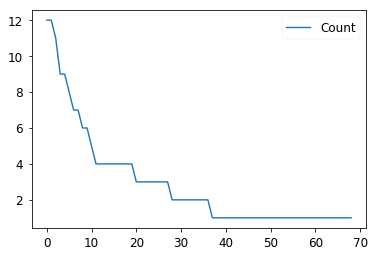

In [692]:
# See the long tail of low frequency doctrines
instance_distributions.plot()

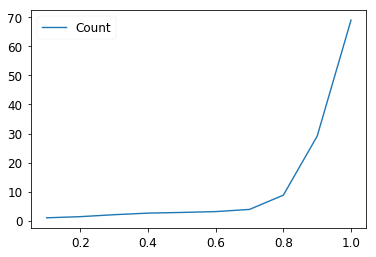

In [693]:
instance_distributions.describe().quantile(np.arange(0.1, 1.1, 0.1)).plot()

### Unique and shared doctrines


In [694]:
def count_unique_doctrines():
    q = ("MATCH (a:Author)--(t:Text)--(:Question)--(i:Instance)--(d:Doctrine) "
         "WITH collect(distinct a) as authors, d "
         "WHERE size(authors) = 1 "
         "UNWIND authors as author "
         "return count(distinct d) as cnt, author.name as name")
    return {d['name']: d['cnt'] for d in graph.run(q).data()}

# Example
unique = count_unique_doctrines()

In [695]:
def count_shared_doctrines(name):
    q = ("MATCH (a:Author)--(:Text)--(:Question)--(i:Instance)--(d:Doctrine) "
         "MATCH (d)--(:Instance)--(:Question)--(:Text)--(a2:Author) "
         "WHERE (a) <> (a2) "
         "return count(distinct d) as cnt, a.name as name")
    return {d['name']: d['cnt'] for d in graph.run(q).data()}

# Example
shared = count_shared_doctrines('John of Jandun')

In [696]:
def unique_to_shared_proportion(name, unique_dict, shared_dict):
    unique = unique_dict.get(name, 0)
    shared = shared_dict.get(name, 0)
    try:
        return unique / (unique + shared)
    except ZeroDivisionError:
        return 0
    
# Example
unique_to_shared_proportion('John of Jandun', unique, shared)

0.40625

Now let's get the values of these for all the commentators and put them into a matrix.

In [697]:
def unique_shared_doctrines_all(authors, unique_dict, shared_dict):
    d = {}
    for a in authors:
        unique = unique_dict.get(a, 0)
        shared = shared_dict.get(a, 0)
        prop = unique_to_shared_proportion(a, unique_dict, shared_dict)
        
        d[a] = [unique, shared, unique + shared, round(prop, 2)]
    return d

# Example
m = unique_shared_doctrines_all(author_names, unique, shared)

Put this in a DataFrame and sort according to most unique.

In [698]:
df = pd.DataFrame(m, index=['Unique', 'Shared', 'Sum', 'Proportion'])
df = df.T.sort_values(by='Proportion', ascending=False)
df[['Unique', 'Shared', 'Sum']] = df[['Unique', 'Shared', 'Sum']].astype(int)
df

,Unique,Shared,Sum,Proportion
Anonymus Digby 55,5,4,9,0.56
John of Jandun,13,19,32,0.41
Siger of Brabant,2,6,8,0.25
Radulphus Brito,7,22,29,0.24
Anonymus Bazan,3,16,19,0.16
Anonymus Assisi,1,14,15,0.07
Simon of Faversham,1,13,14,0.07
Henric de la Wyle,1,15,16,0.06
John Dinsdale,1,18,19,0.05
Anonymus Vat. Lat. 2170 2,0,12,12,0.00


In [699]:
save_table(
    table=df.to_latex(),
    filename='../thesis/data/tables/process-unique-shared-doctrines.tex',
    label='tab:process:unique-shared-doctrines',
    caption='Unique, shared, total and proportion of unique and shared doctrines.'
)

Printed the following table to ../thesis/data/tables/process-unique-shared-doctrines.tex:
 \begin{table}
\centering
\begin{tabular}{lrrrr}
\toprule
{} &  Unique &  Shared &  Sum &  Proportion \\
\midrule
Anonymus Digby 55         &  5 &  4 &  9 &  0.56 \\
John of Jandun            &  13 &  19 &  32 &  0.41 \\
Siger of Brabant          &  2 &  6 &  8 &  0.25 \\
Radulphus Brito           &  7 &  22 &  29 &  0.24 \\
Anonymus Bazan            &  3 &  16 &  19 &  0.16 \\
Anonymus Assisi           &  1 &  14 &  15 &  0.07 \\
Simon of Faversham        &  1 &  13 &  14 &  0.07 \\
Henric de la Wyle         &  1 &  15 &  16 &  0.06 \\
John Dinsdale             &  1 &  18 &  19 &  0.05 \\
Anonymus Vat. Lat. 2170 2 &  0 &  12 &  12 &  0.00 \\
\bottomrule
\end{tabular}
\caption{Unique, shared, total and proportion of unique and shared doctrines.}
\label{tab:process:unique-shared-doctrines}
\end{table}



In [700]:
# The sums?
df[['Unique', 'Shared', 'Sum']].sum()

Unique    34 
Shared    139
Sum       173
dtype: int64

Notice that these numbers are not identical to the sums above. A unique doctrine is a doctrine that has at least one instantiation by exactly one author (i.e. he may use it more than once), while a shared doctrine has at least one instantiation two or more authors. 

This means that the number is a combination of doctrines and instantiations, and is therefore not identical to the separate doctrine and instance sums above. Any correspondence between the two is coincidental.

In [558]:
# Statistical summary
df.describe()

,Unique,Shared,Sum,Proportion
count,10.000000,10.000000,10.000000,10.00000
mean,3.400000,14.200000,17.600000,0.18300
std,4.005552,5.884065,8.289217,0.17783
min,0.000000,4.000000,8.000000,0.00000
25%,1.000000,12.250000,12.500000,0.06250
50%,1.500000,14.500000,15.500000,0.11000
75%,4.500000,17.750000,19.750000,0.24500
max,13.000000,23.000000,33.000000,0.56000


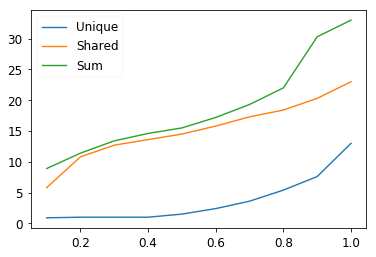

In [379]:
# Plot of the decentiles of unique, shared and sums
df[['Unique', 'Shared', 'Sum']].quantile(np.arange(0.1, 1.1, 0.1)).plot()

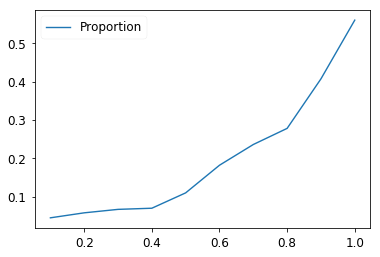

In [380]:
# Plot of the decentiles of the unique-shared proportions
df[['Proportion']].quantile(np.arange(0.1, 1.1, 0.1)).plot()

### Most popular determination and rationes doctrines

#### Rationes doctrines

In [599]:
q = ("match (d:Doctrine)-[:OF]-(i:Instance {type:'Conclusion'})--(:Question)--(:Text)--(a:Author)"
     "return distinct d.description as conclusions, collect(distinct a.name) as names, count(distinct i) as uses "
     "order by uses desc")
graph.run(q).to_table()

conclusions,names,uses
Self-knowledge through external species,"['Anonymus Vat. Lat. 2170 2', 'Anonymus Assisi', 'John Dinsdale', 'Henric de la Wyle', 'John of Jandun', 'Simon of Faversham']",6
The intellect is self-intelligible,"['Anonymus Bazan', 'Anonymus Digby 55', 'John of Jandun']",4
The intellect is intelligible,"['Anonymus Bazan', 'Anonymus Assisi', 'Radulphus Brito']",3
Agent intellect known through its products,"['Anonymus Bazan', 'Radulphus Brito']",2
The intellect knows its own power,['Radulphus Brito'],1
The intellect can observe its own activity,['Radulphus Brito'],1
The agent intellect can be understood by the possible intellect,['Anonymus Bazan'],1


#### Attacking doctrines

In [635]:
q = ("match (d:Doctrine)<-[:OF]-(i:Instance {type:'Attack'})<-[:HAS]-(q:Question)--(:Text)--(a:Author)"
     "return distinct d.description as Description, count(distinct i) as Uses, count(distinct a) as User_count, collect(distinct a.name) as Users "
     "order by length(Users) desc")
popular_attacking = graph.run(q).to_data_frame()
popular_attacking


,Description,User_count,Users,Uses
0,Identity of knower and known in immaterial substances,5,"[Anonymus Vat. Lat. 2170 2, Anonymus Assisi, John Dinsdale, Henric de la Wyle, Simon of Faversham]",5
1,Intellect not available to sense perception,5,"[Anonymus Bazan, Henric de la Wyle, John of Jandun, Radulphus Brito, Siger of Brabant]",11
2,Essential self-knowledge in separate intelligences,5,"[Anonymus Vat. Lat. 2170 2, Anonymus Assisi, John Dinsdale, Henric de la Wyle, Simon of Faversham]",5
3,Mover and moved,4,"[Anonymus Bazan, Anonymus Digby 55, John of Jandun, Radulphus Brito]",4
4,Knowing the act of the intellect risks infinite regress,4,"[Anonymus Vat. Lat. 2170 2, John Dinsdale, John of Jandun, Radulphus Brito]",4
5,No abstraction of the intellect,3,"[Anonymus Bazan, John Dinsdale, Radulphus Brito]",3
6,Analogy with sense and sensation,3,"[Anonymus Bazan, John of Jandun, Radulphus Brito]",4
7,Intellect not its own proper object of knowledge,2,"[Anonymus Bazan, Radulphus Brito]",2
8,Self-knowledge by innate species,2,"[Henric de la Wyle, Simon of Faversham]",2
9,Essential self-knowledge by self-presence,2,"[Anonymus Assisi, John Dinsdale]",2


## High level clusters: Proportional distribution matrices

### Determinations

In [670]:
def proportion_shared_determination_doctrines(name):
    q = ("MATCH (a1:Author {name:'%s'})--(:Text)--(:Question)--(ia:Instance)--(d:Doctrine) "
         "WHERE NOT EXISTS(ia.type) OR ia.type = 'Conclusion' "
         "MATCH (a2:Author)--(:Text)--(:Question)--(ib:Instance)--(d) "
         "WHERE NOT EXISTS(ib.type) OR ib.type = 'Conclusion' " 
         "MATCH (a1)--(:Text)--(:Question)--(i1:Instance)--(d1:Doctrine) "
         "WHERE NOT EXISTS(i1.type) OR i1.type = 'Conclusion' "
         "MATCH (a2)--(:Text)--(:Question)--(i2:Instance)--(d2:Doctrine) "
         "WHERE NOT EXISTS(i2.type) OR i2.type = 'Conclusion' "
         "WITH a2.name as name, count(distinct d) as shared, count(distinct d1) as sum1, count(distinct d2) as sum2 "
         "RETURN name, toFloat(shared) / (sum1 + sum2 - shared) as proportion" % name)
    return {d['name']: d['proportion'] for d in graph.run(q).data()}

proportion_shared_determination_doctrines('John Dinsdale')

{'Anonymus Assisi': 0.4,
 'Anonymus Bazan': 0.125,
 'Anonymus Vat. Lat. 2170 2': 0.7777777777777778,
 'Henric de la Wyle': 0.7777777777777778,
 'John Dinsdale': 1.0,
 'John of Jandun': 0.21052631578947367,
 'Radulphus Brito': 0.3157894736842105,
 'Siger of Brabant': 0.07142857142857142,
 'Simon of Faversham': 0.6363636363636364}

In [671]:
d = build_matrix(author_names, docfunc=proportion_shared_determination_doctrines)        

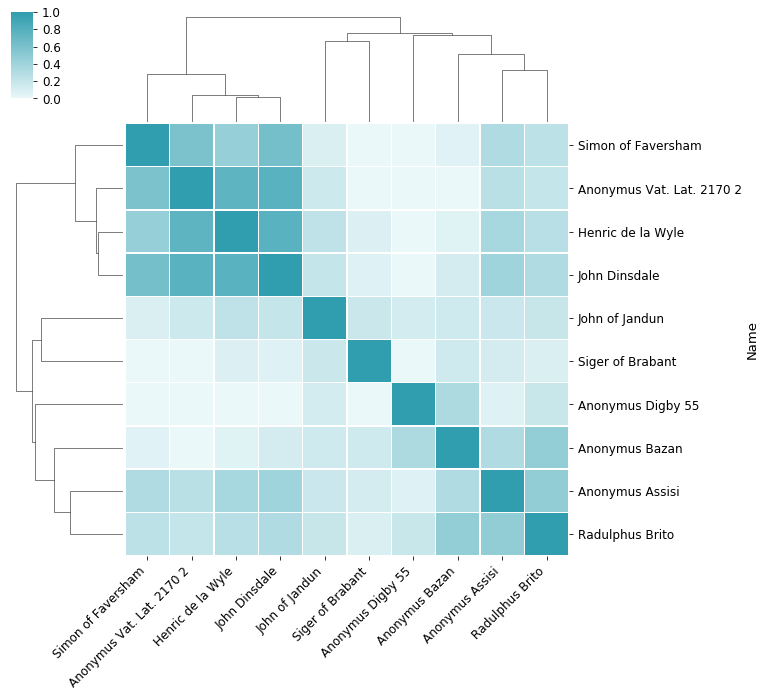

In [672]:
doctrine_frame = pd.DataFrame(d, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(doctrine_frame, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')


In [673]:
plot.savefig('../thesis/data/figures/process-determ-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/process-determ-proportional-clustermap',
    caption='Proportional clustermap of determination doctrines.',
    label='fig:process:determ:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-determ-proportional-clustermap.pdf}
\caption{Proportional clustermap of determination doctrines.}
\label{fig:process:determ:prop-clustermap}
\end{figure}


### Rationes

In [674]:
def proportion_shared_rationes_doctrines(name):
    q = ("MATCH (a1:Author {name:'%s'})--(:Text)--(:Question)--(ia:Instance)--(d:Doctrine) "
         "WHERE ia.type = 'Attack' or ia.type = 'Refutation' "
         "MATCH (a2:Author)--(:Text)--(:Question)--(ib:Instance)--(d) "
         "WHERE ib.type = 'Attack' or ib.type = 'Refutation' " 
         "MATCH (a1)--(:Text)--(:Question)--(i1:Instance)--(d1:Doctrine) "
         "WHERE i1.type = 'Attack' or i1.type = 'Refutation' "
         "MATCH (a2)--(:Text)--(:Question)--(i2:Instance)--(d2:Doctrine) "
         "WHERE i2.type = 'Attack' or i2.type = 'Refutation' "
         "WITH a2.name as name, count(distinct d) as shared, count(distinct d1) as sum1, count(distinct d2) as sum2 "
         "RETURN name, toFloat(shared) / (sum1 + sum2 - shared) as proportion" % name)
    return {d['name']: d['proportion'] for d in graph.run(q).data()}

proportion_shared_rationes_doctrines('John of Jandun')

{'Anonymus Bazan': 0.23076923076923078,
 'Anonymus Digby 55': 0.08,
 'Anonymus Vat. Lat. 2170 2': 0.04,
 'Henric de la Wyle': 0.034482758620689655,
 'John Dinsdale': 0.06666666666666667,
 'John of Jandun': 1.0,
 'Radulphus Brito': 0.2,
 'Siger of Brabant': 0.047619047619047616,
 'Simon of Faversham': 0.038461538461538464}

In [675]:
rationes_matrix = build_matrix(author_names, docfunc=proportion_shared_rationes_doctrines)

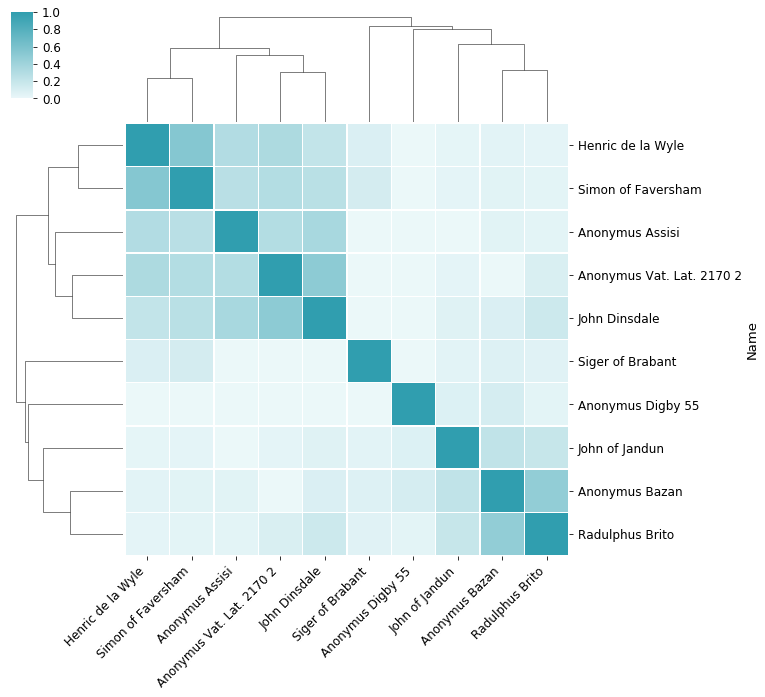

In [676]:
rationes_frame = pd.DataFrame(rationes_matrix, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(rationes_frame, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [677]:
plot.savefig('../thesis/data/figures/process-rationes-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/process-rationes-proportional-clustermap',
    caption='Proportional clustermap of rationes doctrines.',
    label='fig:process:rationes:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-rationes-proportional-clustermap.pdf}
\caption{Proportional clustermap of rationes doctrines.}
\label{fig:process:rationes:prop-clustermap}
\end{figure}


### All doctrines

In [678]:
def proportion_shared_doctrines(name):
    q = ("MATCH (a1:Author {name:'%s'})--(:Text)--(:Question)--(ia:Instance)--(d:Doctrine) "
         "MATCH (a2:Author)--(:Text)--(:Question)--(ib:Instance)--(d) "
         "MATCH (a1)--(:Text)--(:Question)--(i1:Instance)--(d1:Doctrine) "
         "MATCH (a2)--(:Text)--(:Question)--(i2:Instance)--(d2:Doctrine) "
         "WITH a2.name as name, count(distinct d) as shared, count(distinct d1) as sum1, count(distinct d2) as sum2 "
         "RETURN name, toFloat(shared) / (sum1 + sum2 - shared) as proportion" % name)
    return {d['name']: d['proportion'] for d in graph.run(q).data()}

dinsdale = proportion_shared_doctrines('John Dinsdale')

In [679]:
#Example table of dinsdale
dinsdale_df = pd.DataFrame(dinsdale, index=['Proportion']).round(2)
dinsdale_df.index.name = 'Name'
dinsdale_df = dinsdale_df.T.sort_values(ascending=False, by='Proportion')
dinsdale_df

Name,Proportion
John Dinsdale,1.00
Anonymus Vat. Lat. 2170 2,0.63
Anonymus Assisi,0.42
Henric de la Wyle,0.40
Simon of Faversham,0.38
Radulphus Brito,0.26
John of Jandun,0.16
Anonymus Bazan,0.12
Siger of Brabant,0.08


In [680]:
print(dinsdale_df.to_latex())

\begin{tabular}{lr}
\toprule
Name &  Proportion \\
\midrule
John Dinsdale             &  1.00 \\
Anonymus Vat. Lat. 2170 2 &  0.63 \\
Anonymus Assisi           &  0.42 \\
Henric de la Wyle         &  0.40 \\
Simon of Faversham        &  0.38 \\
Radulphus Brito           &  0.26 \\
John of Jandun            &  0.16 \\
Anonymus Bazan            &  0.12 \\
Siger of Brabant          &  0.08 \\
\bottomrule
\end{tabular}



In [681]:
all_matrix = build_matrix(author_names, docfunc=proportion_shared_doctrines)

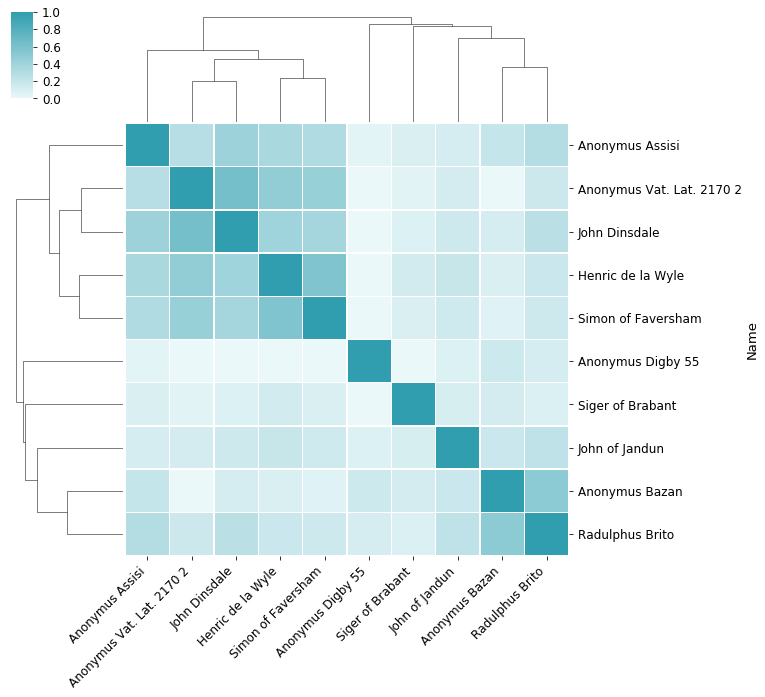

In [682]:
all_frame = pd.DataFrame(all_matrix, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(all_frame, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [684]:
plot.savefig('../thesis/data/figures/process-all-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/process-all-proportional-clustermap',
    caption='Proportional clustermap of all doctrines.',
    label='fig:process:all:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-all-proportional-clustermap.pdf}
\caption{Proportional clustermap of all doctrines.}
\label{fig:process:all:prop-clustermap}
\end{figure}


Get a path of specific combinations
This matches supporting to a level of 8 nodes.
```
match (:Conclusion)-[:OF]->(dc:Doctrine)
call apoc.path.expand(dc, "<SUPPORTS,<SUPPORTS|<IMPLIES|OF>", "Instance|Doctrine", 1, 8) yield path as pp
return pp
```

# Create doctrinal matrix
Here we want to create a matrix table where it can be seen in more detail which doctrines each commentator uses. It is probably a good idea to distinguish between determination doctrines and rationes doctrines.

First we pull out a list of the names of the doctrines in determinations of each commentator.

## Determination doctrines

In [215]:
def determination_doctrines_of(name):
    q = ("MATCH (a:Author {name:'%s'})--(t:Text)--(q:Question)--(i:Instance)--(d:Doctrine) "
         "WHERE not exists(i.type) or i.type = 'Conclusion' "
         "RETURN distinct d.description as Doctrine " % name )
    return [d['Doctrine'] for d in graph.run(q).data()]

# Example test
determination_doctrines_of("John of Jandun")

['Perpetual self-knowledge of agent intellect not available to humans',
 'Possible and agent intellect joined in constant knowledge',
 'Agent intellect most suitable object of knowledge',
 'Self-knowledge different from the science of the soul',
 'The intellect has essential self-knowledge',
 'Essential self-knowledge results in no self-knowledge',
 'Understanding a blocking activity',
 'Self-knowledge by innate species',
 'Substantial knowledge from accidents',
 'Self-knowledge through external species',
 'Possible intellect completely indeterminate before actualization by external species',
 'The intellect is self-intelligible',
 'Self-intelligible through external species',
 'The intellect is intelligible like any other thing']

Then we create a full list of all the doctrines in determinations.

In [207]:
def all_determination_doctrines():
    q = ("MATCH (i:Instance)--(d:Doctrine) "
         "WHERE not exists(i.type) or i.type = 'Conclusion' "
         "RETURN distinct d.description as Doctrine")
    return [d['Doctrine'] for d in graph.run(q).data()]

all_determination_docs = all_determination_doctrines()

# Test output
all_determination_docs

['Agent intellect known through its products',
 'The intellect is intelligible',
 'Intellect intelligble through external species',
 'The intellect is self-intelligible',
 'Successive self-knowledge',
 'Self-intelligible through external species',
 'The intellect knows its own power',
 'The intellect can observe its own activity',
 'Superiority to sense-perception',
 'Intelligibility requires actuality',
 'An immaterial substance is self-reflexive',
 'The intellect is intelligible like any other thing',
 'The intellect has essential self-knowledge',
 'Identity of knower and known in immaterial substances',
 'Self-knowledge through external species',
 'Possible intellect completely indeterminate before actualization by external species',
 'Analogy with vision: Only things visible in act can be perceived',
 'Substantial knowledge from accidents',
 'Possible intellect similar to prime matter',
 'Great chain of being and the intellect',
 'Understanding a blocking activity',
 'Science of th

Now for each author we register how many of the doctrines he ticks off and reads that into a matrix.

In [232]:
matrix = {}
for author in author_names:
    matrix[author] = []
    adocs = determination_doctrines_of(author)
    for doc in all_determination_docs:
        if doc in adocs:
            matrix[author].append(1)
        else:
            matrix[author].append(0)


determination_df = pd.DataFrame(matrix, index=all_determination_docs)
determination_df

,Anonymus Assisi,Anonymus Bazan,Anonymus Digby 55,Anonymus Vat. Lat. 2170 2,Henric de la Wyle,John Dinsdale,John of Jandun,Radulphus Brito,Siger of Brabant,Simon of Faversham
Agent intellect known through its products,0,1,0,0,0,0,0,1,1,0
The intellect is intelligible,1,1,0,0,0,0,0,1,0,0
Intellect intelligble through external species,1,1,0,0,0,0,0,1,0,0
The intellect is self-intelligible,0,1,1,0,0,0,1,1,0,0
Successive self-knowledge,1,1,1,0,0,0,0,1,0,0
Self-intelligible through external species,0,1,1,0,0,0,1,1,0,0
The intellect knows its own power,0,0,0,0,0,0,0,1,0,0
The intellect can observe its own activity,0,0,0,0,0,0,0,1,0,0
Superiority to sense-perception,0,0,0,0,0,0,0,1,0,0
Intelligibility requires actuality,1,1,0,0,0,1,0,1,0,1


In [209]:
sums = determination_df.sum().sort_values(ascending=False)
sums

Radulphus Brito              16
John of Jandun               14
Anonymus Assisi              12
Simon of Faversham            9
John Dinsdale                 9
Anonymus Bazan                9
Henric de la Wyle             7
Anonymus Vat. Lat. 2170 2     7
Siger of Brabant              6
Anonymus Digby 55             3
dtype: int64

What is the mean amount of doctrines?

In [210]:
determination_df.sum().mean()

9.2

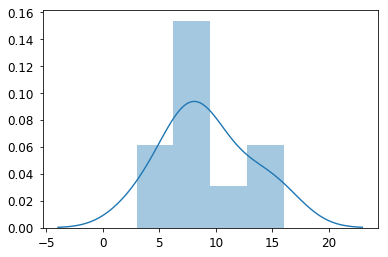

In [211]:
sns.distplot(determination_df.sum())

### Popularity of arguments

In [601]:
determination_df.sum(axis=1).sort_values(ascending=False)

NameError: name 'determination_df' is not defined

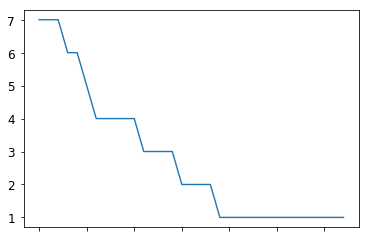

In [258]:
determination_df.sum(axis=1).sort_values(ascending=False).plot()

### Binary matrix cluster analysis
So what if we take the binary matrix representing the presence or absence of a doctrine and use that for clustering?
I have used this as an inspiration: https://stats.stackexchange.com/questions/222492/any-distance-measures-that-are-more-useful-for-binary-data-clustering.
As suggested in the post we use the Hamming metric for distance measuring, as that just counts the number of coordinates that differ. AS it is also mentioned in the scipy documentation it can therefore be used for boolean matrices (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html).

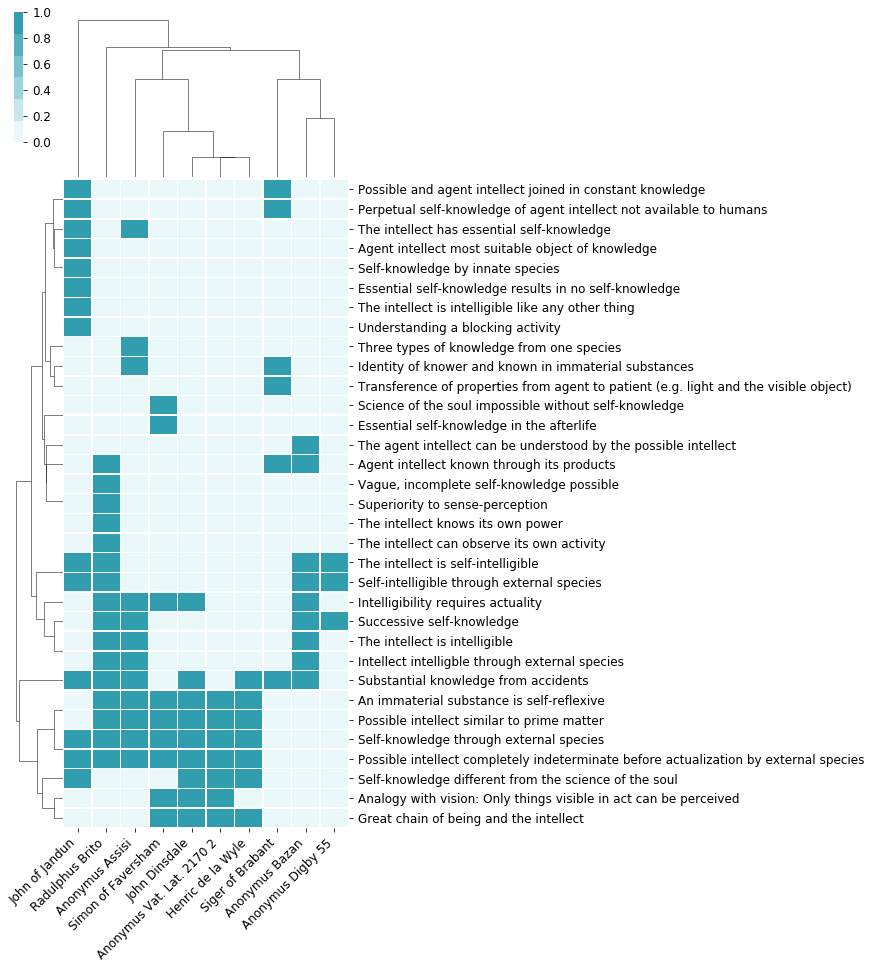

In [264]:
# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(determination_df, cmap=cmap, linewidths=.5, figsize=(6, 15), row_cluster=True, metric='hamming')

for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [265]:
plot.savefig('../thesis/data/figures/process-determination-binary-clustermap.pdf')
print_figure_inclusion(
    'process-determinations-binary-clustermap.pdf', plot,
    caption='Binary doctrinal matrix of determination doctrines.',
    label='fig:process:determination:binary-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-determinations-binary-clustermap.pdf}
\caption{Binary clustermap of determination doctrines.}
\label{fig:process:determination:binary-clustermap}
\end{figure}


## Rationes doctrines

In [586]:
def rationes_doctrines_of(name):
    q = ("MATCH (a:Author {name:'%s'})--(t:Text)--(q:Question)--(i:Instance)--(d:Doctrine) "
         "WHERE i.type = 'Attack' OR i.type = 'Refutation' "
         "RETURN distinct d.description as Doctrine " % name )
    return [d['Doctrine'] for d in graph.run(q).data()]

# Example test
rationes_doctrines_of("John of Jandun")

['Intellect not available to sense perception',
 'The intellect can understand completely immaterial things',
 'All intelligibles become intellects if intellect is intelligible',
 'Self-intelligible through external species',
 'The intellect is self-intelligible',
 'An immaterial substance is self-reflexive',
 'Other objects of knowledge have no self-knowledge',
 'Nothing can move itself (knowledge is being-moved)',
 'Primary and secondary intelligibility',
 'Mover and moved',
 'Act and potency with different respects',
 'No simultaneous act and potency',
 'Sense cannot perceive own action because of their corporeality',
 'Analogy with sense and sensation',
 'Intellect cannot understand objects of different natures',
 'Diversification only a problem with same mode of being',
 'Multiple simultaneous objects of understanding is possible',
 'Knowing the act of the intellect risks infinite regress',
 'Multiple simultaneous objects of understanding impossible',
 'Accidents cannot affect the

Then we create a full list of all the doctrines in rationes.

In [587]:
def all_rationes_doctrines():
    q = ("MATCH (i:Instance)--(d:Doctrine) "
         "WHERE i.type = 'Attack' OR i.type = 'Refutation' "
         "RETURN distinct d.description as Doctrine")
    return [d['Doctrine'] for d in graph.run(q).data()]

all_rationes_docs = all_rationes_doctrines()

# Test output
all_rationes_docs

['The intellect can observe its own activity',
 'Analogy with sense and sensation',
 'Sense cannot perceive own action because of their corporeality',
 'Mover and moved',
 'The intellect is intelligible',
 'Intellect not its own proper object of knowledge',
 'The intellect is self-intelligible',
 'Primary and secondary intelligibility',
 'The intellect knows its own power',
 'Only restriction of identity in physical movement',
 'Intellect not available to sense perception',
 'Intellect is perceptible after actualization',
 'Knowing the act of the intellect risks infinite regress',
 'No simultaneous act and potency',
 'Act and potency with different respects',
 'Infinite regress not a problem in the intellect',
 'Only physical movement requires difference between mover and moved',
 'Nothing can move itself (knowledge is being-moved)',
 'Accidents cannot affect their own subject',
 'Multiple simultaneous objects of understanding is possible',
 'Multiple simultaneous objects of understand

Now for each author we register how many of the doctrines he ticks off and reads that into a matrix.

In [588]:
matrix = {}
for author in author_names:
    matrix[author] = []
    adocs = rationes_doctrines_of(author)
    for doc in all_rationes_docs:
        if doc in adocs:
            matrix[author].append(1)
        else:
            matrix[author].append(0)


rationes_df = pd.DataFrame(matrix, index=all_rationes_docs)
rationes_df

,Anonymus Assisi,Anonymus Bazan,Anonymus Digby 55,Anonymus Vat. Lat. 2170 2,Henric de la Wyle,John Dinsdale,John of Jandun,Radulphus Brito,Siger of Brabant,Simon of Faversham
The intellect can observe its own activity,0,0,0,0,0,0,0,1,0,0
Analogy with sense and sensation,0,1,0,0,0,0,1,1,0,0
Sense cannot perceive own action because of their corporeality,0,1,0,0,0,0,1,1,0,0
Mover and moved,0,1,1,0,0,0,1,1,0,0
The intellect is intelligible,0,1,0,0,0,0,0,1,0,0
Intellect not its own proper object of knowledge,1,1,0,0,0,1,0,1,0,0
The intellect is self-intelligible,0,1,1,0,0,0,1,0,0,0
Primary and secondary intelligibility,0,1,0,0,0,0,1,1,0,0
The intellect knows its own power,0,0,0,0,0,0,0,1,0,0
Only restriction of identity in physical movement,0,1,0,0,0,0,0,1,0,0


In [589]:
sums = rationes_df.sum().sort_values(ascending=False)
sums

John of Jandun               20
Radulphus Brito              16
John Dinsdale                12
Anonymus Bazan               12
Henric de la Wyle            10
Simon of Faversham           7 
Anonymus Digby 55            7 
Anonymus Assisi              7 
Anonymus Vat. Lat. 2170 2    6 
Siger of Brabant             2 
dtype: int64

What is the mean amount of doctrines?

In [590]:
rationes_df.sum().mean()

9.9

In [591]:
sns.distplot(determination_df.sum())

NameError: name 'determination_df' is not defined

### Popularity of arguments

In [592]:
rationes_df.sum(axis=1).sort_values(ascending=False)

Intellect not available to sense perception                                             6
Essential self-knowledge in separate intelligences                                      5
Possible intellect completely indeterminate before actualization by external species    5
Identity of knower and known in immaterial substances                                   5
Mover and moved                                                                         4
Intellect not its own proper object of knowledge                                        4
Knowing the act of the intellect risks infinite regress                                 4
No identity of knower and known before actualization of possible intellect              3
Analogy with sense and sensation                                                        3
Sense cannot perceive own action because of their corporeality                          3
Infinite regress not a problem in the intellect                                         3
The intell

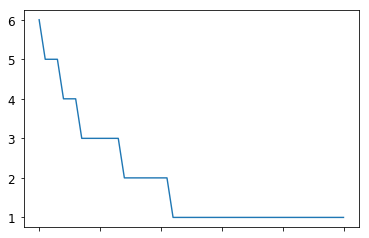

In [593]:
rationes_df.sum(axis=1).sort_values(ascending=False).plot()

### Binary matrix cluster analysis


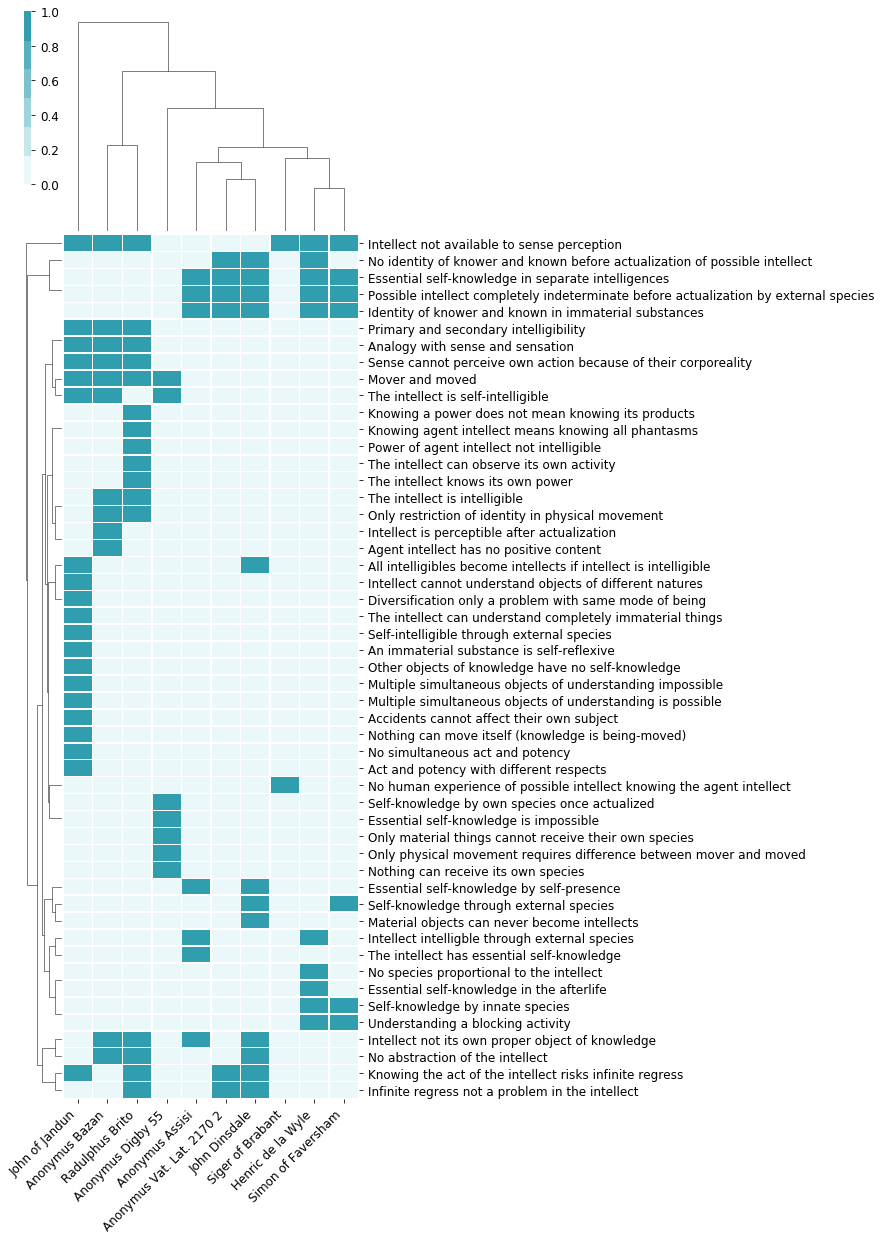

In [594]:
# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(rationes_df, cmap=cmap, linewidths=.5, figsize=(6, 20), row_cluster=True, metric='hamming')

for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [595]:
plot.savefig('../thesis/data/figures/process-rationes-binary-clustermap.pdf')
print_figure_inclusion(
    'process-rationes-binary-clustermap.pdf', plot,
    caption='Binary doctrinal matrix of rationes doctrines.',
    label='fig:process:rationes:binary-clustermap')

TypeError: print_figure_inclusion() got multiple values for argument 'caption'

# Quantifying centrality

Can we see whether there are some commentators who take up a central position in terms of how big a proportion of doctrines they contain?

Can we also sort them by how by a proportion of the most common doctrines they contain? Will there be any difference between such two measures?

In [602]:
q = ('MATCH (n:Author) RETURN n.name as Name, id(n) as ID ORDER BY n.name asc')
df = graph.run(q).to_data_frame()
author_names = df['Name']
df

,ID,Name
0,4,Anonymus Assisi
1,2,Anonymus Bazan
2,3,Anonymus Digby 55
3,1,Anonymus Vat. Lat. 2170 2
4,6,Henric de la Wyle
5,5,John Dinsdale
6,7,John of Jandun
7,8,Radulphus Brito
8,554,Siger of Brabant
9,10,Simon of Faversham


## Most common doctrines and who has most of them

Who has the highest proportion of the most common doctrines?

First we find the most popular doctrines. Let's take the upper quartile.

In [603]:
# Doctrine count instance distributions
q = ("MATCH (i:Instance)-[:OF]->(d:Doctrine) "
     "RETURN count(distinct i) as Count, d.description as Description "
     "ORDER BY Count DESC")
instance_distributions = graph.run(q).to_data_frame()

In [604]:
popular_df = instance_distributions[instance_distributions['Count'] >= int(instance_distributions.quantile(0.67))]
save_table(
    filename='../thesis/data/tables/process-popular-doctrines.tex', 
    table=popular_df.to_latex(index=False),
    caption='Top one third of determination doctrines according to popularity.',
    label='tab:process:most-popular-doctrines')

Printed the following table to ../thesis/data/tables/process-popular-doctrines.tex:
 \begin{table}
\centering
\begin{tabular}{rl}
\toprule
 Count &                                                                           Description \\
\midrule
 12 &  Intellect not available to sense perception \\
 12 &  Primary and secondary intelligibility \\
 11 &  Possible intellect completely indeterminate before actualization by external species \\
 9 &  An immaterial substance is self-reflexive \\
 9 &  Substantial knowledge from accidents \\
 8 &  Self-knowledge through external species \\
 7 &  Identity of knower and known in immaterial substances \\
 7 &  Intellect intelligble through external species \\
 6 &  Great chain of being and the intellect \\
 6 &  Possible intellect similar to prime matter \\
 5 &  Essential self-knowledge in separate intelligences \\
 4 &  Intellect not its own proper object of knowledge \\
 4 &  Successive self-knowledge \\
 4 &  Mover and moved \\
 4 &  Sense ca

Then, to find out who presents most of these doctrines:
- Read all the doctrines of all the commentators into a dictionary.
- For each commentator, calculate how big a proportion of the most common doctrines he uses.

In [605]:
q = ("MATCH (a:Author)--(:Text)--(:Question)--(:Instance)--(d:Doctrine) "
     "RETURN a.name as Name, collect(distinct d.description) as Doctrines")
commentator_doctrines = {d['Name']: set(d['Doctrines']) for d in graph.run(q).data()}

In [606]:
popular_proportion = {}
popular_set = set(popular_df['Description'])
for name, doctrines in commentator_doctrines.items():
    popular_proportion[name] = len(popular_set & doctrines) / len(popular_set)
popular_proportion

{'Anonymus Assisi': 0.42857142857142855,
 'Anonymus Bazan': 0.5357142857142857,
 'Anonymus Digby 55': 0.14285714285714285,
 'Anonymus Vat. Lat. 2170 2': 0.42857142857142855,
 'Henric de la Wyle': 0.4642857142857143,
 'John Dinsdale': 0.5714285714285714,
 'John of Jandun': 0.5,
 'Radulphus Brito': 0.75,
 'Siger of Brabant': 0.14285714285714285,
 'Simon of Faversham': 0.39285714285714285}

Now let's put the values into a DataFrame for presetational purposes.

In [607]:
popular_prop_df = pd.DataFrame(popular_proportion, index=['Proportion'])
popular_prop_df.index.name = 'Name'
popular_props = popular_prop_df.T.sort_values(ascending=False, by='Proportion').round(2)
save_table(
    filename='../thesis/data/tables/process-popular-proportion.tex', 
    table=popular_props.to_latex(),
    caption='Proportion of most popular doctrines by commentator.',
    label='tab:process:most-popular-proportion')

Printed the following table to ../thesis/data/tables/process-popular-proportion.tex:
 \begin{table}
\centering
\begin{tabular}{lr}
\toprule
Name &  Proportion \\
\midrule
Radulphus Brito           &  0.75 \\
John Dinsdale             &  0.57 \\
Anonymus Bazan            &  0.54 \\
John of Jandun            &  0.50 \\
Henric de la Wyle         &  0.46 \\
Anonymus Assisi           &  0.43 \\
Anonymus Vat. Lat. 2170 2 &  0.43 \\
Simon of Faversham        &  0.39 \\
Anonymus Digby 55         &  0.14 \\
Siger of Brabant          &  0.14 \\
\bottomrule
\end{tabular}
\caption{Proportion of most popular doctrines by commentator.}
\label{tab:process:most-popular-proportion}
\end{table}



In [608]:
commentator_doctrines[popular_props.index[0]] & popular_set

{'Agent intellect known through its products',
 'An immaterial substance is self-reflexive',
 'Analogy with sense and sensation',
 'Infinite regress not a problem in the intellect',
 'Intellect intelligble through external species',
 'Intellect not available to sense perception',
 'Intellect not its own proper object of knowledge',
 'Intelligibility requires actuality',
 'Knowing the act of the intellect risks infinite regress',
 'Mover and moved',
 'No abstraction of the intellect',
 'Possible intellect completely indeterminate before actualization by external species',
 'Possible intellect similar to prime matter',
 'Primary and secondary intelligibility',
 'Self-intelligible through external species',
 'Self-knowledge through external species',
 'Sense cannot perceive own action because of their corporeality',
 'Substantial knowledge from accidents',
 'Successive self-knowledge',
 'The intellect is intelligible',
 'The intellect is self-intelligible'}

In [609]:
commentator_doctrines[popular_props.index[1]] & popular_set

{'An immaterial substance is self-reflexive',
 'Analogy with vision: Only things visible in act can be perceived',
 'Essential self-knowledge in separate intelligences',
 'Great chain of being and the intellect',
 'Identity of knower and known in immaterial substances',
 'Infinite regress not a problem in the intellect',
 'Intellect not its own proper object of knowledge',
 'Intelligibility requires actuality',
 'Knowing the act of the intellect risks infinite regress',
 'No abstraction of the intellect',
 'No identity of knower and known before actualization of possible intellect',
 'Possible intellect completely indeterminate before actualization by external species',
 'Possible intellect similar to prime matter',
 'Self-knowledge different from the science of the soul',
 'Self-knowledge through external species',
 'Substantial knowledge from accidents'}

In [610]:
commentator_doctrines[popular_props.index[2]] & popular_set

{'Agent intellect known through its products',
 'Analogy with sense and sensation',
 'Intellect intelligble through external species',
 'Intellect not available to sense perception',
 'Intellect not its own proper object of knowledge',
 'Intelligibility requires actuality',
 'Mover and moved',
 'No abstraction of the intellect',
 'Primary and secondary intelligibility',
 'Self-intelligible through external species',
 'Sense cannot perceive own action because of their corporeality',
 'Substantial knowledge from accidents',
 'Successive self-knowledge',
 'The intellect is intelligible',
 'The intellect is self-intelligible'}

## One-sided commonality

Now, let's look at the data in the more one sided perspective of how big a proportion of the material of one commentator is also to be found in the others (regardless of their shared sum of material). So this is the uni-directional, non-symmetric relation. 

This can be described by the metaphor or "outgoing" material, as it lists how much of the doctrines of the starting commentator (`name`) are present in any other commentator.

The hypothesis is that this can be used to investigate which commentators have material that is also present in a high proportion of the other commentators (regardless of how much unique material they might have).

In [611]:
def corpus_count_doctrines():
    """
    Return the number of doctrines in the corpus.
    """
    q = ("MATCH (corpus:Doctrine) RETURN count(distinct corpus) as count ")
    return graph.run(q).evaluate()


corpus_count = corpus_count_doctrines()

In [612]:
distributions = graph.run("match (a:Author)--(:Text)--(:Question)--(:Instance)--(d:Doctrine) "
                              "return count(distinct d) as cnt, a.name order by cnt desc").to_data_frame()
distributions.describe()

,cnt
count,10.000000
mean,17.300000
std,7.888811
min,8.000000
25%,12.500000
50%,15.500000
75%,19.000000
max,32.000000


In [614]:
def outgoing_shared_material(name):
    """
    Return a dictionary of how big a proportion 
    of his doctrines the searched commentator 
    shares with all the others.
    """
    q = ("MATCH (a1:Author {name:'%s'})--(:Text)--(:Question)--(:Instance)--(shared:Doctrine)--(:Instance)--(:Question)--(:Text)--(a2:Author)  "
         "WHERE (a1) <> (a2) "
         "MATCH (a1)--(:Text)--(:Question)--(:Instance)--(own:Doctrine) " 
         "RETURN a2.name as name, count(distinct shared) as shared, count(distinct own) as own " % name)
    return {r['name']:  r['shared'] / r['own'] for r in graph.run(q).data()}

unidir_single = outgoing_shared_material('Anonymus Vat. Lat. 2170 2')
unidir_single

{'Anonymus Assisi': 0.5,
 'Henric de la Wyle': 0.75,
 'John Dinsdale': 1.0,
 'John of Jandun': 0.4166666666666667,
 'Radulphus Brito': 0.5,
 'Siger of Brabant': 0.08333333333333333,
 'Simon of Faversham': 0.6666666666666666}

This function normalizes the values against the proportion of doctrines of the author compared to the full corpus. This results in much lower values than the absolute proportions, but corrects for the inaccuracy that rises when the number of doctrines of the author is far from the corpus average.

### Uni-directional overlap in full matrix

This shows how big a proportion of the doctrines of one commentator are also to be found in each of the others. 

This is not a symmetrical relation. 

This will show much much of the material of the column commnentator (X) is present in the others (Y). This only shows how big a proportion of the material (X) is also found in each of the others (Y). It thus does not show how close the two are to each other but merely how close the X is to Y.

Now let's try to build a matrix of those values for all the commentators. By default each column (X) will contain the array of results from the above function. 


In [615]:
uni_rel = build_matrix(author_names, docfunc=outgoing_shared_material)
matrix = pd.DataFrame(uni_rel, index=author_names)
matrix

,Anonymus Assisi,Anonymus Bazan,Anonymus Digby 55,Anonymus Vat. Lat. 2170 2,Henric de la Wyle,John Dinsdale,John of Jandun,Radulphus Brito,Siger of Brabant,Simon of Faversham
Name,,,,,,,,,,
Anonymus Assisi,0.000000,0.315789,0.111111,0.500000,0.5000,0.526316,0.15625,0.344828,0.250,0.500000
Anonymus Bazan,0.400000,0.000000,0.444444,0.000000,0.1875,0.210526,0.25000,0.551724,0.375,0.142857
Anonymus Digby 55,0.066667,0.210526,0.000000,0.000000,0.0000,0.000000,0.09375,0.137931,0.000,0.000000
Anonymus Vat. Lat. 2170 2,0.400000,0.000000,0.000000,0.000000,0.5625,0.631579,0.15625,0.206897,0.125,0.571429
Henric de la Wyle,0.533333,0.157895,0.000000,0.750000,0.0000,0.526316,0.25000,0.241379,0.375,0.785714
John Dinsdale,0.666667,0.210526,0.000000,1.000000,0.6250,0.000000,0.21875,0.344828,0.250,0.642857
John of Jandun,0.333333,0.421053,0.333333,0.416667,0.5000,0.368421,0.00000,0.413793,0.500,0.428571
Radulphus Brito,0.666667,0.842105,0.444444,0.500000,0.4375,0.526316,0.37500,0.000000,0.375,0.428571
Siger of Brabant,0.133333,0.157895,0.000000,0.083333,0.1875,0.105263,0.12500,0.103448,0.000,0.142857


**Rescaling (normalization):** 
This function is used to scale all the values of a dataframe to lie within the range `[0,1]` to counteract the fact that the normalization against corpus proportion results in very small numbers.

As we use both the values of the columns and rows, we just copy those two transformations of the matrix into two variables.

The difference is the following: 
- The `columns` contains what can be thought of (inaccurately) as outgoing proportions. This will show how much of the material of the column commnentator (X) is present in the others (Y).
- The `rows` contains what can be thought of (inaccurately) as ingoing proportions. This will show how much of the material of the column commentator (X) that is identical with the total doctrines of the row commentator (Y).

In [616]:
cols = matrix
rows = matrix.T

#### Single author proportions

Now with this matrix we can get any of the columns to see the data on that commentator.

In [617]:
cols['John of Jandun'].sort_values(ascending=False)

Name
Radulphus Brito              0.37500
Henric de la Wyle            0.25000
Anonymus Bazan               0.25000
John Dinsdale                0.21875
Simon of Faversham           0.18750
Anonymus Vat. Lat. 2170 2    0.15625
Anonymus Assisi              0.15625
Siger of Brabant             0.12500
Anonymus Digby 55            0.09375
John of Jandun               0.00000
Name: John of Jandun, dtype: float64

This for example shows how big a proportion of Jandun's doctrines are also used by e.g. Brito, Bazan and Wyle (39%, 27%, and 23% as of this writing). 

#### Concentration factor

If we calculate the mean of each of those columns we get a single value for how strong a tendency there is for the doctrines of an author to also be present in other authors.

In other words, this is an indication of how big a proportion of the doctrines of each column commentator other commentators use. 

This means that reading the text of a commentator with a high concetration score, the reader is more likely to read doctrines that are also present in other texts.

In [618]:
concentration = cols.mean().sort_values(ascending=False).round(2)

In [619]:
concentration

Anonymus Vat. Lat. 2170 2    0.39
Henric de la Wyle            0.37
Anonymus Assisi              0.37
Simon of Faversham           0.36
John Dinsdale                0.34
Radulphus Brito              0.26
Siger of Brabant             0.25
Anonymus Bazan               0.24
John of Jandun               0.18
Anonymus Digby 55            0.13
dtype: float64

In [620]:
save_table(
    filename='../thesis/data/tables/process-mean-concentration.tex', 
    table=concentration.to_frame('Proportion').to_latex(),
    caption='Standardized mean concentration factors.',
    label='tab:process:mean-concentration-factor')

Printed the following table to ../thesis/data/tables/process-mean-concentration.tex:
 \begin{table}
\centering
\begin{tabular}{lr}
\toprule
{} &  Proportion \\
\midrule
Anonymus Vat. Lat. 2170 2 &  0.39 \\
Henric de la Wyle         &  0.37 \\
Anonymus Assisi           &  0.37 \\
Simon of Faversham        &  0.36 \\
John Dinsdale             &  0.34 \\
Radulphus Brito           &  0.26 \\
Siger of Brabant          &  0.25 \\
Anonymus Bazan            &  0.24 \\
John of Jandun            &  0.18 \\
Anonymus Digby 55         &  0.13 \\
\bottomrule
\end{tabular}
\caption{Standardized mean concentration factors.}
\label{tab:process:mean-concentration-factor}
\end{table}



Let's collect the two measurements into one and calculate an average.

In [624]:
exemplary = pd.DataFrame(popular_prop_df.T['Proportion'])
exemplary['Concentration'] = concentration
exemplary.columns = ['Common doctrines', 'Concentration']
exemplary['Average'] = (exemplary['Common doctrines'] + exemplary['Concentration']) / 2
exemplary = exemplary.sort_values(by='Average', ascending=False).round(2)
exemplary

,Common doctrines,Concentration,Average
Radulphus Brito,0.75,0.26,0.50
John Dinsdale,0.57,0.34,0.46
Henric de la Wyle,0.46,0.37,0.42
Anonymus Vat. Lat. 2170 2,0.43,0.39,0.41
Anonymus Assisi,0.43,0.37,0.40
Anonymus Bazan,0.54,0.24,0.39
Simon of Faversham,0.39,0.36,0.38
John of Jandun,0.50,0.18,0.34
Siger of Brabant,0.14,0.25,0.20
Anonymus Digby 55,0.14,0.13,0.14


In [625]:
save_table(
    filename='../thesis/data/tables/central-commentators.tex', 
    table=exemplary.to_latex(),
    caption='Proportions of popular doctrines, concentration indices, and the averages.',
    label='tab:process:central-commentators')

Printed the following table to ../thesis/data/tables/central-commentators.tex:
 \begin{table}
\centering
\begin{tabular}{lrrr}
\toprule
{} &  Common doctrines &  Concentration &  Average \\
\midrule
Radulphus Brito           &  0.75 &  0.26 &  0.50 \\
John Dinsdale             &  0.57 &  0.34 &  0.46 \\
Henric de la Wyle         &  0.46 &  0.37 &  0.42 \\
Anonymus Vat. Lat. 2170 2 &  0.43 &  0.39 &  0.41 \\
Anonymus Assisi           &  0.43 &  0.37 &  0.40 \\
Anonymus Bazan            &  0.54 &  0.24 &  0.39 \\
Simon of Faversham        &  0.39 &  0.36 &  0.38 \\
John of Jandun            &  0.50 &  0.18 &  0.34 \\
Siger of Brabant          &  0.14 &  0.25 &  0.20 \\
Anonymus Digby 55         &  0.14 &  0.13 &  0.14 \\
\bottomrule
\end{tabular}
\caption{Proportions of popular doctrines, concentration indices, and the averages.}
\label{tab:process:central-commentators}
\end{table}



### Who have high out-going overlap?

Now we can also take the max value of each of column in the recipiency matrix to reveal whether there are some commentators who have a very high out-going overlap, i.e. what the highest outgoing value this commentator has.

In [626]:
max_values_outgoing = pd.DataFrame(cols.max().sort_values(ascending=False), columns=['Value']).round(2)
col = {name: ', '.join(cols.index[cols[name] == cols[name].max()].tolist()) for name in cols.index}
max_values_outgoing['Commentator(s)'] = pd.Series(col)
max_values_outgoing

,Value,Commentator(s)
Anonymus Vat. Lat. 2170 2,1.00,John Dinsdale
Anonymus Bazan,0.84,Radulphus Brito
Simon of Faversham,0.79,Henric de la Wyle
Henric de la Wyle,0.69,Simon of Faversham
Anonymus Assisi,0.67,"John Dinsdale, Radulphus Brito"
John Dinsdale,0.63,Anonymus Vat. Lat. 2170 2
Radulphus Brito,0.55,Anonymus Bazan
Siger of Brabant,0.50,John of Jandun
Anonymus Digby 55,0.44,"Anonymus Bazan, Radulphus Brito"
John of Jandun,0.38,Radulphus Brito


This may be interesting to give hints about possible inheritance or inspiration.

### Top most shared with each of the max outliers

In [631]:
cols['Anonymus Vat. Lat. 2170 2'].sort_values(ascending=False).head(4)

Name
John Dinsdale         1.000000
Henric de la Wyle     0.750000
Simon of Faversham    0.666667
Radulphus Brito       0.500000
Name: Anonymus Vat. Lat. 2170 2, dtype: float64

In [633]:
cols['Anonymus Bazan'].sort_values(ascending=False).head(4)

Name
Radulphus Brito    0.842105
John of Jandun     0.421053
Anonymus Assisi    0.315789
John Dinsdale      0.210526
Name: Anonymus Bazan, dtype: float64

In [634]:
cols['Simon of Faversham'].sort_values(ascending=False).head(4)

Name
Henric de la Wyle            0.785714
John Dinsdale                0.642857
Anonymus Vat. Lat. 2170 2    0.571429
Anonymus Assisi              0.500000
Name: Simon of Faversham, dtype: float64

## Experimentation with data extraction

In [650]:
def doctrines_of(name):
    q = ("MATCH (q:Question)--(t:Text)--(a:Author {name:'%s'}) "
         "MATCH (q)-[:HAS]->(i:Instance)-->(d:Doctrine) "
         "return distinct d.description " % name)
    return graph.run(q)
doctrines_of('John of Jandun').to_data_frame()

,d.description
0,Perpetual self-knowledge of agent intellect not available to humans
1,Intellect not available to sense perception
2,The intellect can understand completely immaterial things
3,Possible and agent intellect joined in constant knowledge
4,Agent intellect most suitable object of knowledge
5,Self-knowledge different from the science of the soul
6,The intellect has essential self-knowledge
7,Essential self-knowledge results in no self-knowledge
8,Understanding a blocking activity
9,Self-knowledge by innate species


In [657]:
def list_attacks(name):
    q = ("MATCH (q:Question)--(t:Text)--(a:Author {name:'%s'}) "
         "MATCH (attack:Instance {type:'Attack'})-[:OF]-(ad:Doctrine) "
         "WHERE (q)-[:HAS]->(attack) "
         "return distinct q.title as Question, ad.description as Attack "
         "order by Question "% name)
    return graph.run(q)

In [652]:
def list_refutations(name):
    q = ("MATCH (q:Question)--(t:Text)--(a:Author {name:'%s'}) "
         "MATCH (refut:Doctrine)<-[:OF]-(refi:Instance {type:'Refutation'})-[:ATTACKS]->(ad:Doctrine) "
         "WHERE (refi)<-[:HAS]-(q) "
         "return distinct q.title as Question, refut.description as Refutation, ad.description as Attack "
         "order by Question " % name)
    return graph.run(q)

In [653]:
def list_uncategorized_attacks(name):
    q = ("MATCH (q:Question)--(t:Text)--(a:Author {name:'%s'}) "
         "MATCH (s:Doctrine)<-[:OF]-(i:Instance)-[:ATTACKS]->(ad:Doctrine) "
         "WHERE (i)<-[:HAS]-(q) "
         "AND NOT exists(i.type) "
         "return distinct q.title as Question, s.description as Source, ad.description as Target "
         "order by Question " % name)
    return graph.run(q)

In [659]:
def list_uncategorized_doctrines(name):
    q = ("MATCH (q:Question)--(t:Text)--(a:Author {name:'%s'}) "
         "MATCH (s:Doctrine)<-[:OF]-(i:Instance) "
         "WHERE (i)<-[:HAS]-(q) "
         "AND NOT exists(i.type) or i.type='Conclusion' "
         "return distinct q.title as Question, s.description as Source "
         "order by Question " % name)
    return graph.run(q)
list_uncategorized_doctrines('John of Jandun').to_data_frame()

,Question,Source
0,Whether the possible intellect always understands the agent intellect with a numerically identical understanding,The intellect is intelligible
1,Whether the possible intellect always understands the agent intellect with a numerically identical understanding,The intellect can observe its own activity
2,Whether the possible intellect always understands the agent intellect with a numerically identical understanding,The intellect is self-intelligible
3,Whether the possible intellect always understands the agent intellect with a numerically identical understanding,The intellect knows its own power
4,Whether the possible intellect always understands the agent intellect with a numerically identical understanding,Self-knowledge through external species
5,Whether the possible intellect always understands the agent intellect with a numerically identical understanding,The agent intellect can be understood by the possible intellect
6,Whether the possible intellect always understands the agent intellect with a numerically identical understanding,Agent intellect most suitable object of knowledge
7,Whether the possible intellect always understands the agent intellect with a numerically identical understanding,Agent intellect known through its products
8,Whether the possible intellect always understands the agent intellect with a numerically identical understanding,Possible and agent intellect joined in constant knowledge
9,Whether the possible intellect always understands the agent intellect with a numerically identical understanding,Perpetual self-knowledge of agent intellect not available to humans


In [663]:
q = ("MATCH (d:Doctrine)<-[:OF]-(i:Instance)--(q:Question)--(t:Text)--(a:Author {name:'Siger of Brabant'}) "
     "return distinct q.title as Question, d.description as Doctrine, i.type as Type "
     "order by Question ")
graph.run(q).to_data_frame()

,Doctrine,Question,Type
0,Substantial knowledge from accidents,Whether the possible intellect can know the agent intellect,None
1,Agent intellect known through its products,Whether the possible intellect can know the agent intellect,None
2,Perpetual self-knowledge of agent intellect not available to humans,Whether the possible intellect can know the agent intellect,None
3,Transference of properties from agent to patient (e.g. light and the visible object),Whether the possible intellect can know the agent intellect,None
4,Identity of knower and known in immaterial substances,Whether the possible intellect can know the agent intellect,None
5,No human experience of possible intellect knowing the agent intellect,Whether the possible intellect can know the agent intellect,Attack
6,Intellect not available to sense perception,Whether the possible intellect can know the agent intellect,Attack
7,Possible and agent intellect joined in constant knowledge,Whether the possible intellect can know the agent intellect,None


In [655]:
list_uncategorized_attacks('Simon of Faversham').to_data_frame()

""


### Attacks

In [656]:
list_attacks('Siger of Brabant').to_data_frame()

,Attack,Question
0,No human experience of possible intellect knowing the agent intellect,Whether the possible intellect can know the agent intellect
1,Intellect not available to sense perception,Whether the possible intellect can know the agent intellect


In [55]:
list_attacks('Radulphus Brito').to_data_frame()

,Attack,Question
0,No abstraction of the intellect,Whether our possible intellect can understand ...
1,All knowledge must be based on sense perception,Whether our possible intellect can understand ...
2,Power of agent intellect not intelligible,Whether our possible intellect can understand ...
3,Knowing agent intellect means knowing all phan...,Whether our possible intellect can understand ...
4,Analogy with sense and sensation,Whether the intellect can know its act and pow...
5,Intellect not its own proper object of knowledge,Whether the intellect can know its act and pow...
6,Intellect not available to sense perception,Whether the intellect can know its act and pow...
7,Knowing the act of the intellect risks infinit...,Whether the intellect can know its act and pow...
8,Mover and moved,Whether the intellect is intelligible
9,Intellect not available to sense perception,Whether the intellect is intelligible


In [56]:
list_attacks('Anonymus Bazan').to_data_frame()

,Attack,Question
0,No abstraction of the intellect,Whether our possible intellect can understand ...
1,All knowledge must be based on sense perception,Whether our possible intellect can understand ...
2,Agent intellect has no positive content,Whether our possible intellect can understand ...
3,Intellect not its own proper object of knowledge,Whether the intellect can understand the act o...
4,Intellect not available to sense perception,Whether the intellect can understand the act o...
5,Analogy with sense and sensation,Whether the intellect can understand the act o...
6,Intellect not available to sense perception,Whether the possible intellect is intelligible
7,Mover and moved,Whether the possible intellect is intelligible


In [57]:
list_refutations('Anonymus Bazan').to_data_frame()[['Refutation', 'Attack', 'Question']]

,Refutation,Attack,Question
0,Primary and secondary intelligibility,No abstraction of the intellect,Whether our possible intellect can understand ...
1,Primary and secondary intelligibility,All knowledge must be based on sense perception,Whether our possible intellect can understand ...
2,Intellect is perceptible after actualization,Intellect not available to sense perception,Whether the intellect can understand the act o...
3,Primary and secondary intelligibility,Intellect not its own proper object of knowledge,Whether the intellect can understand the act o...
4,Sense cannot perceive own action because of th...,Analogy with sense and sensation,Whether the intellect can understand the act o...
5,Intellect is perceptible after actualization,Intellect not available to sense perception,Whether the possible intellect is intelligible
6,Only restriction of identity in physical movement,Mover and moved,Whether the possible intellect is intelligible


In [58]:
list_refutations('Radulphus Brito').to_data_frame()[['Refutation', 'Attack', 'Question']]

,Refutation,Attack,Question
0,Primary and secondary intelligibility,No abstraction of the intellect,Whether our possible intellect can understand ...
1,Primary and secondary intelligibility,All knowledge must be based on sense perception,Whether our possible intellect can understand ...
2,Knowing a power does not mean knowing its prod...,Power of agent intellect not intelligible,Whether our possible intellect can understand ...
3,Knowing a power does not mean knowing its prod...,Knowing agent intellect means knowing all phan...,Whether our possible intellect can understand ...
4,Primary and secondary intelligibility,Intellect not available to sense perception,Whether the intellect can know its act and pow...
5,Primary and secondary intelligibility,Intellect not its own proper object of knowledge,Whether the intellect can know its act and pow...
6,Sense cannot perceive own action because of th...,Analogy with sense and sensation,Whether the intellect can know its act and pow...
7,Infinite regress not a problem in the intellect,Knowing the act of the intellect risks infinit...,Whether the intellect can know its act and pow...
8,Primary and secondary intelligibility,Intellect not available to sense perception,Whether the intellect is intelligible
9,Only restriction of identity in physical movement,Mover and moved,Whether the intellect is intelligible


In [59]:
list_refutations('John of Jandun').to_data_frame()[['Refutation', 'Attack', 'Question']]

,Refutation,Attack,Question
0,The intellect can understand completely immate...,All knowledge must be based on sense perception,Whether the possible intellect always understa...
1,Primary and secondary intelligibility,Intellect not available to sense perception,Whether the possible intellect can know itself
2,Sense cannot perceive own action because of th...,Analogy with sense and sensation,Whether the possible intellect can know itself
3,Primary and secondary intelligibility,Mover and moved,Whether the possible intellect can know itself
4,Act and potency with different respects,No simultaneous act and potency,Whether the possible intellect can know itself
5,Primary and secondary intelligibility,Nothing can move itself (knowledge is being-mo...,Whether the possible intellect can know itself
6,Self-intelligible through external species,All intelligibles become intellects if intelle...,Whether the possible intellect can know itself
7,An immaterial substance is self-reflexive,Other objects of knowledge have no self-knowledge,Whether the possible intellect can know itself
8,Primary and secondary intelligibility,Intellect not available to sense perception,Whether the possible intellect can understand ...
9,Sense cannot perceive own action because of th...,Analogy with sense and sensation,Whether the possible intellect can understand ...
